In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import roc_auc_score, r2_score, log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import optuna
from lightgbm import LGBMClassifier, record_evaluation, plot_importance

from scipy.special import logit
import scipy.stats as sps
from scipy.stats.distributions import chi2

from typing import Union, Tuple


sns.set(style='darkgrid', palette='deep')

# Загрузим данные

- Данные упорядочены по времени
- Задача - предсказать `target`
- Фичи - `feature_i`
- Трейн, валидация и тест уже определены (см. колонку `sample_part`)

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/WreJPgb9pJS687D). Пароль в канале курса.

In [ ]:
df = pd.read_parquet('df.parquet.gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 22620 to 310653
Columns: 235 entries, date to sample_part
dtypes: category(2), datetime64[ms](1), datetime64[us](2), float64(220), int64(9), object(1)
memory usage: 893.6+ MB


In [ ]:
df.head()

,date,month,quarter,feature_217,feature_66,feature_9,feature_193,feature_15,feature_199,feature_25,...,feature_20,feature_188,feature_71,feature_106,feature_14,feature_92,feature_179,feature_102,target,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,1.180855,0.483118,13.976791,1.135021,43.271792,-46.888875,97.558366,...,23.745198,-32.001093,85.489903,1.454045,-195.725786,3.719083,1,-28.813537,0.0,train
478621,2021-01-01,2021-01-01,2021-01-01,3.427814,0.886778,27.158209,-0.378728,80.087863,-67.242703,105.803406,...,22.902111,-37.436243,71.735619,1.657242,-176.250404,3.277817,1,-45.987721,1.0,train
372254,2021-01-01,2021-01-01,2021-01-01,-38.555018,1.227175,19.893873,0.498787,98.464365,-67.402522,81.858076,...,21.848414,-51.872841,65.363236,1.626874,-178.116798,2.028950,0,-31.074122,1.0,train
2596,2021-01-01,2021-01-01,2021-01-01,-14.666558,0.753129,18.203010,-1.200014,117.331340,-25.557745,90.277266,...,26.134586,-49.703003,65.013659,1.170023,-192.232264,2.218177,1,-36.703897,0.0,train
216892,2021-01-01,2021-01-01,2021-01-01,6.734990,1.129100,11.245920,-0.108955,61.205722,-78.397406,82.637472,...,24.201039,-41.070219,69.986127,1.630795,-200.155528,3.055104,1,-44.672299,1.0,train


In [ ]:
TARGET = 'target'
N_FEATURES = 230
features = [f'feature_{i}' for i in range(N_FEATURES)]

In [ ]:
categ_mask = df.nunique() < 200 # Положим признак категориальным, если в нем меньше 200 уникальных значений

In [ ]:
categ_features = list(set(df.columns[categ_mask]) - set(['month','quarter','sample_part','target']))
numeric_features = list(set(features) - set(categ_features))

In [ ]:
len(categ_features)

15

In [ ]:
len(numeric_features)

215

# Первичный отбор признаков... (1 балл)

**Задание:** Сначала отсеем совсем уж мусорные признаки.

Воспользовавшись вашим кодом для вычисления `IV` из прошлой домашки, для всех **числовых** фичей вычислите `IV` на 20 бакетах. Отсейте признаки с `IV < 0.005`.

**Hint:** паркет не всегда сохраняет `dtype` колонки. Чтобы проверить признаки на "реальный" тип данных, лучше на всякий случай посмотреть на `nunique`

In [ ]:
# Одним блоком идет дальше функции для построения woe_line из предыдущего дз

def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets


def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""

    woe = logit(badrate) - offset
    return woe


def get_interval_boundaries(p, n, flag = 0, alpha=0.05):
  """Вычисление левой/правой границы интервала Вальда для badrate"""
  z = sps.norm.ppf(1-alpha/2) # Нужная квантиль
  sts = z * np.sqrt(p * (1 - p) / n) # Статистика для границ интервала
  return max(0, p - sts) if flag == 0 else min(1, p + sts) # Если flag 0, то вернется левая граница, иначе - правая


def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[np.ndarray]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""

    # группируем target по bucket и вычисляем badrate (просто среднее по таргету) и количество наблюдений в bucket
    grouped = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['mean', 'count'])['target']
    # векторизованная функция вычисления границ интервала
    vFunc = np.vectorize(get_interval_boundaries)

    # считаем бэдрейт и доверительный интервал для него (любым способом)
    badrate = grouped['mean'].values
    badrate_lower = vFunc(grouped['mean'], grouped['count'], 0)
    badrate_upper = vFunc(grouped['mean'], grouped['count'], 1)

    # переходим от бэдрейта к woe
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)

    return woe, woe_lower, woe_upper


def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""
    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    logreg_ = LogisticRegression().fit(np.expand_dims(values, axis=1),target)
    proba = logreg_.predict_proba(np.expand_dims(mean_feature, axis=1))[:, 1]
    line = woe_transform(proba, offset)
    return line


def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    # Находим среднее фича по buckets
    grouped_mean = pd.DataFrame(data = {'feature': values, 'bucket': buckets}).groupby('bucket')['feature'].mean().values
    offset = logit(np.mean(target))
    # Вычисляем информацию по woe
    woe_inf = woe_ci(target, buckets, offset)
    buckets_info = {
        "mean_feature" : grouped_mean,
        "line"         : calc_line(values, target, grouped_mean, offset),
        "woe"          : woe_inf[0],
        "woe_lower"    : woe_inf[1],
        "woe_upper"    : woe_inf[2]
    }

    return buckets_info


def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    """Считает для признака roc auc, IV, R^2"""
    # ROC-AUC
    auc = roc_auc_score(target, values)

    # Нахождение WoE
    offset = logit(np.mean(target))
    woe, _, _ = woe_ci(target, buckets, offset)

    # Нахождение статистики распределений целевой переменной по buckets и вообще
    buckets_stats = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['sum', 'count'])['target']

    # Статистика для IV
    bad_buckets = buckets_stats['sum']
    good_buckets = buckets_stats['count'] - buckets_stats['sum']
    bad_overall = np.sum(target)
    good_overall = target.shape[0] - bad_overall

    # Непосрдественное вычисление IV
    IV = np.sum((bad_buckets / bad_overall - good_buckets / good_overall) * woe)

    # Взвешенный R^2
    X = np.bincount(buckets, weights=values) / buckets_stats['count']
    woe_pred = calc_line(values, target, X, offset)
    R_sqr = r2_score(woe, woe_pred, sample_weight=buckets_stats['count'], force_finite=np.NaN)

    plot_title = (
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title


def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig


def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : dict = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

In [ ]:
def evaluate_iv(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ):
    '''Отдельная функция для нахождения IV'''
    # Нахождение WoE
    offset = logit(np.mean(target))
    woe, _, _ = woe_ci(target, buckets, offset)

    # Нахождение статистики распределений целевой переменной по buckets и вообще
    buckets_stats = pd.DataFrame(data = {'target':target, 'bucket':buckets}).groupby(['bucket']).agg(['sum', 'count'])['target']

    # Статистика для IV
    bad_buckets = buckets_stats['sum']
    good_buckets = buckets_stats['count'] - buckets_stats['sum']
    bad_overall = np.sum(target)
    good_overall = target.shape[0] - bad_overall

    # Непосрдественное вычисление IV
    IV = np.sum((bad_buckets / bad_overall - good_buckets / good_overall) * woe)

    return IV

In [ ]:
informative_numeric_features = []

for feature in numeric_features:
  if evaluate_iv(df[feature], df['target'], calc_buckets(df[feature], 20)) >= 0.005:
    informative_numeric_features.append(feature)

In [ ]:
len(informative_numeric_features) # Выведем количество оставленных числовых признаков

53

**Вопрос**: Почему некорректно сравнивать `IV` у категориальных и числовых фичей?

***Ответ***: Сравнение может быть некорректным из-за различия в кол-ве уникальных значений. Так, у числовых фичей их как правило значительно больше, а следовательно если мы захотим сравнивать с категориальными по IV, то придется проводить слишком сильную компоновку; из-за этого реальный IV у числового признака может искажаться, что недопустимо

Вычислите IV для категориальных фичей на `n` бакетах, где `n = min(число категорий фичи, 20)`. Возможно, придётся перекодировать некоторые фичи (*только не OneHot-ом!*)

*Опционально*: примените также и к категориальным фичам предварительный отбор по `IV` с менее строгим порогом

In [ ]:
df.select_dtypes(exclude=np.number)

,date,month,quarter,feature_0,feature_209,sample_part
22620,2021-01-01,2021-01-01,2021-01-01,c,PRIV,train
478621,2021-01-01,2021-01-01,2021-01-01,d,GVM,train
372254,2021-01-01,2021-01-01,2021-01-01,c,UNEMP,train
2596,2021-01-01,2021-01-01,2021-01-01,b,PRIV,train
216892,2021-01-01,2021-01-01,2021-01-01,c,UNEMP,train
...,...,...,...,...,...,...
196513,2022-12-30,2022-12-01,2022-10-01,b,UNEMP,test
108604,2022-12-30,2022-12-01,2022-10-01,c,UNEMP,test
141359,2022-12-30,2022-12-01,2022-10-01,b,UNEMP,test
443018,2022-12-30,2022-12-01,2022-10-01,c,UNEMP,test


Перекодируем 2 признака с помощью ```LabelEncoder```

In [ ]:
feat_209_dict = {'UNEMP':1, 'GVM':2, 'PRIV':3}
df['feature_209'] = df['feature_209'].apply(lambda x: feat_209_dict[x]).astype(int)

In [ ]:
feat_0_dict = {'a':1, 'b':2, 'c':3, 'd':4}
df['feature_0'] = df['feature_0'].apply(lambda x: feat_0_dict[x]).astype(int)

In [ ]:
informative_categ_features = []

for feature in categ_features:
  if evaluate_iv(df[feature], df['target'], calc_buckets(df[feature], min(20, df[feature].nunique()))) >= 0.001:
    informative_categ_features.append(feature)

/usr/local/lib/python3.10/dist-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [ ]:
len(informative_categ_features) # Количество оставленных категориальных признаков

10

# Бустинг

## Подбор гиперпараметров бустинга (2 балла)

Теперь подберем оптимальные гиперпараметры бустинга.

In [ ]:
# В переменную features_optuna положите список признаков с предыдущего шага
features_optuna = informative_numeric_features + informative_categ_features

**Задание:** Заполните пропуски в коде ниже и подберите оптимальные гиперпараметры.

Для успешного решения необходимо преодолеть порог ROC-AUC `0.725` на тестовой выборке.

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 2, 30),
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 50, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 50, log=False),
        'random_state': 42
    }

    clf = LGBMClassifier(**params, verbosity=-1)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', features_optuna],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', features_optuna])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )

    return auc_valid

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2024-03-24 09:23:54,741] A new study created in memory with name: no-name-62fafc33-9758-4079-a2b0-2a995ec99849
[I 2024-03-24 09:24:05,981] Trial 0 finished with value: 0.7125155279261777 and parameters: {'learning_rate': 0.6145697685003951, 'num_leaves': 10, 'n_estimators': 70, 'max_depth': 23, 'reg_alpha': 41.97184198359163, 'reg_lambda': 1.0916204681116648}. Best is trial 0 with value: 0.7125155279261777.
[I 2024-03-24 09:24:18,446] Trial 1 finished with value: 0.695814005828072 and parameters: {'learning_rate': 0.8555085572890441, 'num_leaves': 3, 'n_estimators': 171, 'max_depth': 25, 'reg_alpha': 35.50990511368974, 'reg_lambda': 30.74711498605516}. Best is trial 0 with value: 0.7125155279261777.
[I 2024-03-24 09:24:34,259] Trial 2 finished with value: 0.7280441495871783 and parameters: {'learning_rate': 0.7282834059969198, 'num_leaves': 11, 'n_estimators': 153, 'max_depth': 5, 'reg_alpha': 30.2554766788157, 'reg_lambda': 5.408933632411878}. Best is trial 2 with value: 0.72804414

In [ ]:
print(study.best_params)

{'learning_rate': 0.4100934516612288, 'num_leaves': 24, 'n_estimators': 243, 'max_depth': 16, 'reg_alpha': 15.568445726707566, 'reg_lambda': 15.239718608499112}


In [ ]:
clf = LGBMClassifier(**study.best_params, verbosity=-1)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', features_optuna])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
assert auc_test > 0.725, f'Необходимое значение ROC-AUC 0.725 и выше, ваше значение: {auc_test}!'

## Кривые накопления (1 балл)

**Задание:** Отрисуйте кривые накопления `ROC AUC` от `n_estimators` для бустинга с гиперпараметрами из предыдущего пункта.

**Hint:** для получения auc на каждой итерации обучения `LGBMClassifier`, можно воспользоваться параметрами `eval_set`, `eval_metric` и в методе `fit`.

In [ ]:
history = {}
eval_history = record_evaluation(history)

clf.fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET],
    eval_set=[(df.loc[df['sample_part'] == 'train', features_optuna], df.loc[df['sample_part'] == 'train', TARGET]),
              (df.loc[df['sample_part'] == 'test', features_optuna], df.loc[df['sample_part'] == 'test', TARGET])],
    eval_metric='auc', callbacks= [eval_history]
)

LGBMClassifier(learning_rate=0.4100934516612288, max_depth=16, n_estimators=243,
               num_leaves=24, reg_alpha=15.568445726707566,
               reg_lambda=15.239718608499112, verbosity=-1)

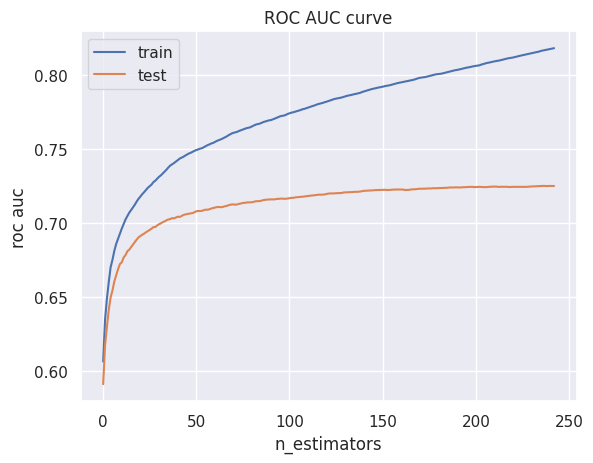

In [ ]:
sns.lineplot(history["valid_0"]["auc"], label='train')
sns.lineplot(history["valid_1"]["auc"], label='test')

plt.title("ROC AUC curve")
plt.xlabel("n_estimators")
plt.ylabel("roc auc")
plt.legend()

plt.show()

**Вопрос:** Что вы видите на полученных графиках?

Нужно ли "обрезать" количество деревьев? Ответ обоснуйте.

По графику видно, что уже начиная с 200 деревьев roc-auc почти не изменяется, но и не ухудшается; в целом, можно оставить такое кол-во деревьев (ну или как раз обрезать до 200 примерно)

## Важность признаков (1 балл)

**Задание:** Постойте гистограмму важности признаков по `split` и `gain` для бустинга из предыдущего пункта.

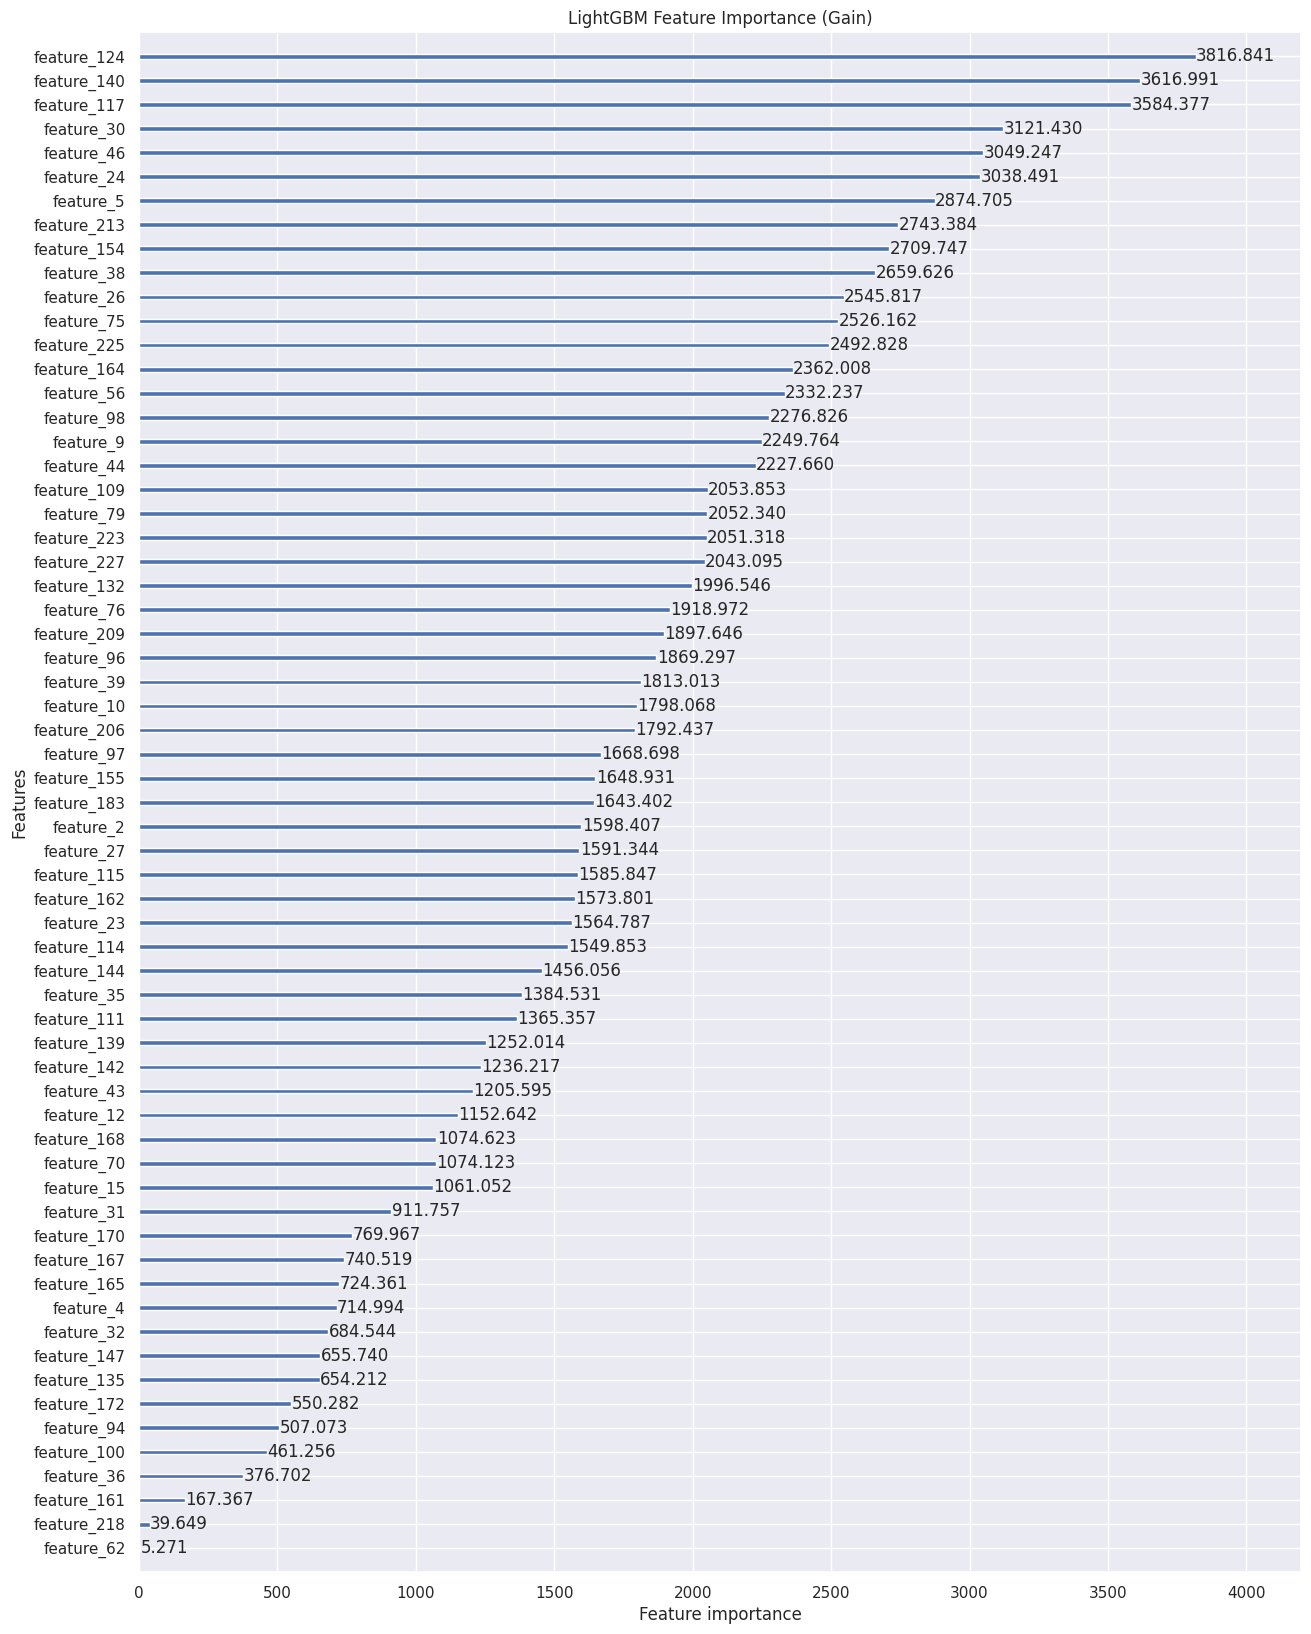

In [ ]:
plot_importance(clf, importance_type="gain", figsize=(15,20), title="LightGBM Feature Importance (Gain)")
plt.show()

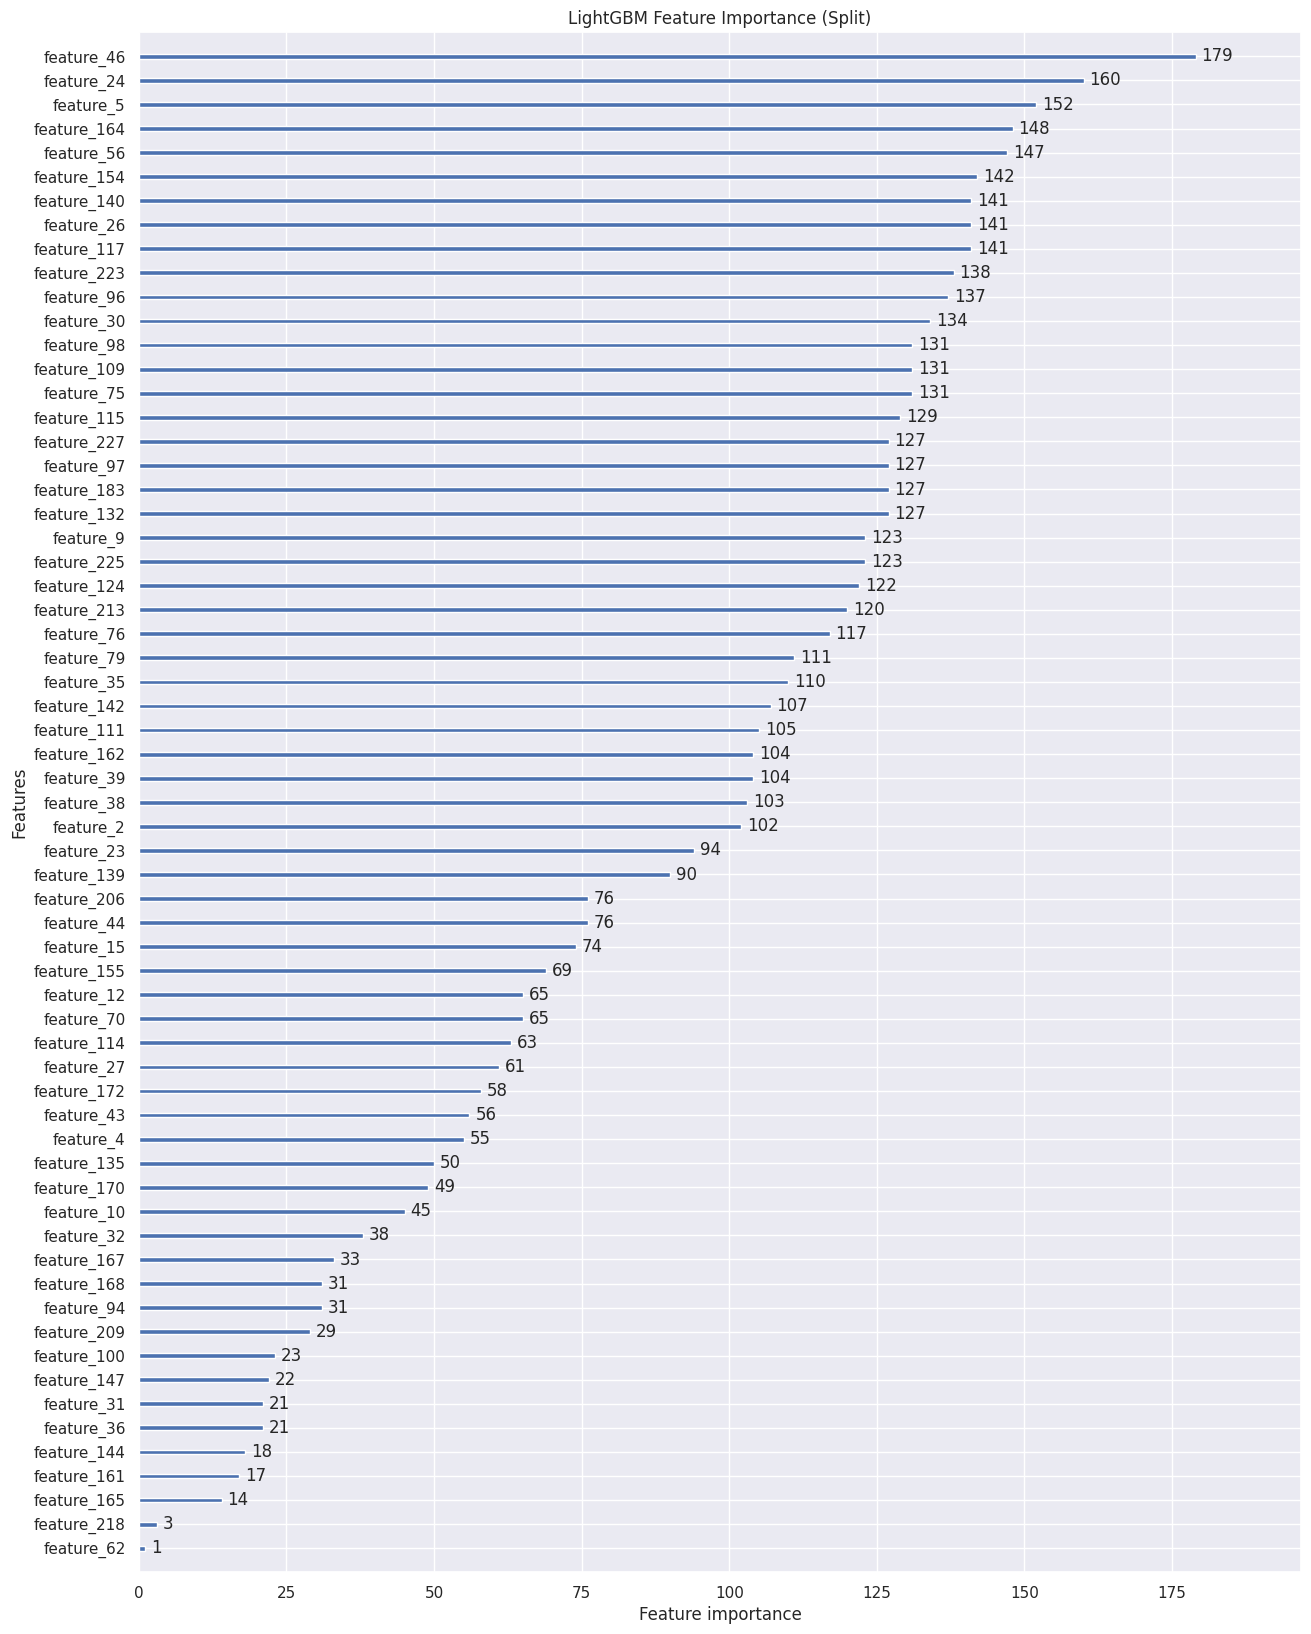

In [ ]:
plot_importance(clf, importance_type="split", figsize=(15,20), title="LightGBM Feature Importance (Split)")
plt.show()

**Вопрос:** Какие выводы можно сделать из полученных графиков?

***Ответ***: Во-первых, можно заметить, что есть признаки, у которых и gain, и split очень маленькие (например ```feature_62``` вообще последняя и там, и там); это свидетельствует о том, что такие признаки мусорные, и их однозначно можно отбросить практически без потери качества. Во-вторых, множества топовых признаков по gain и split имеют много общего (например, ```feature_46``` первая по split и шестая по gain, что тоже достаточно высоко; с другой стороны, ```feature_140``` вторая по gain и седьмая по split); это в свою очередь свидетельствует о важности этих признаков для бустинга (то есть отбрасывать их не стоит). В-третьих, есть ряд "аномальных" признаков, дающих большую прибавку в качестве модели, но при этом не делящихся достаточно часто (так, первая по gain ```feature_124``` по split не входит даже в топ 20).  

Зафиксируем топ-15 признаков по Gain

In [ ]:
split_importance = LGBMClassifier(**best_params, importance_type="gain", verbosity=-1).fit(
    X=df.loc[df['sample_part'] == 'train', features_optuna],
    y=df.loc[df['sample_part'] == 'train', TARGET]).feature_importances_

In [ ]:
top15features_stable = np.array(features_optuna)[np.argsort(split_importance)][-15:]

In [ ]:
top15features_stable

array(['feature_56', 'feature_164', 'feature_225', 'feature_75',
       'feature_26', 'feature_38', 'feature_154', 'feature_213',
       'feature_5', 'feature_24', 'feature_46', 'feature_30',
       'feature_117', 'feature_140', 'feature_124'], dtype='<U11')

# Логрег

## plot_metric_time (1 балл)

**Задание:** Реализуйте функцию plot_metric_time, которая будет принимать на вход четыре аргумента, а именно:
- массив значений фичи,
- массив значений таргета,
- массив времени (аггрегированного по месяцам или кварталам, то есть `month` или `quarter` в вашей задаче, по дням рисовать не надо),
- метрику, которую необходимо отрисовать (нужно реализовать функцию для двух метрик: `IV` и `roc_auc`)
- число бакетов для вычисления `IV`, если выбрана эта метрика

Можете добваить какие-то ещё аргументы, если вам нужно

Если в фиче есть пропуски, функция должна убирать строки с пропусками из рассмотрения

**Hint**: можно, конечно, реализовать эту функцию через цикл, а можно попробовать разобраться и реализовать её через пандасовские `groupby` -> `apply`, это изящнее и быстрее

In [ ]:
def plot_metric_time(
        values: pd.Series,
        target: pd.Series,
        time: pd.Series,
        metric: str = 'IV',
        n_buckets_for_IV: int = 15
) -> go.Figure:
    """
    функция для отрисовки графика стабильности признака во времени
    values — ряд значений признака
    target — ряд значений целевой переменной
    time - ряд значений разбиения на временные отсечки
    metric - метрика для оценки стабильности (IV/roc_auc)
    n_buckets_for_IV - кол-во контейнеров для расчета IV
    Returns
    -----
    fig - фигура с графиком стабильности
    """

    df_ = pd.DataFrame({'feature': values, 'target': target, 'period': time}).dropna().groupby(by='period')

    if metric == 'IV':
        comp_metric = df_.apply(lambda x: evaluate_iv(x.feature, x.target, calc_buckets(x.feature, n_buckets_for_IV)))
    elif metric == 'roc_auc':
        comp_metric = df_.apply(lambda x: roc_auc_score(x.target, x.feature))
    else:
        raise NotImplementedError("only 'IV' and 'roc_auc' metrics are implemented")

    plot_title = metric + " stability plot"
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x= comp_metric.index,
            y= comp_metric.values,
            mode='markers+lines',
            name=values.name
            )
        )

    fig.update_layout(
            title_text=plot_title,
            yaxis=dict(title=metric),
            width=1000,
            height=450,
            xaxis=dict(
                domain=[0, .95],
                showgrid=True,
                tickvals=comp_metric.index
                ),
            showlegend=True,
            margin=dict(l=30, r=30, b=30, t=50),
            )

    fig.show()

    return fig

In [ ]:
# примерно так это должно будет выглядеть
plot_metric_time(df['feature_124'], df['target'], df['month'], metric='IV')

**Задание:** Возьмите **топ-15** фичей получившегося бустинга по важности по `gain`. Отрисуйте для них графики стабильности по `IV` во времени и удалите из рассмотрения те признаки, качество которых деградирует

**NB!** Обращайте внимание на масштаб оси *y!* Иногда признак стабильнее, чем кажется)

Если вам это мешает, можете поменять ось *y*, чтобы она начиналась от нуля в прошлом задании.

In [ ]:
for feature in top15features_stable:
  plot_metric_time(df[feature], df['target'], df['month'], metric='IV')

На графиках видно, что только ```feature_154``` явно деградирует со временем, так что его отбросим; остальные признаки более-менее стабильно (или даже улучшается со временем)

На этом моменте предлагаю сделать новый маленький датафрейм, чтобы не "портить" исходный

И проводить все манипуляции с фичами на нём

In [ ]:
df_for_logreg = df[list(top15features_stable) + ['feature_98', 'feature_44', 'date', 'month', 'quarter', 'target', 'sample_part']].drop(columns=['feature_154'])

## Предобработка признаков (2 балла)

**Задание:** Используя функицю woe_line из предыдущего ДЗ, проверьте **числовые** фичи из полученного списка фичей на линейность по WoE на трейн-выборке (если в фиче есть пропуски - дропаем их при отрисовке)

Если фичи нелинейные, **линеаризуйте их**.

Преобразования, которые можно/стоит пробовать:
- клипы (`np.clip`) - зачастую их достаточно
- корень
- квадрат
- логарифм

Если нужно, можно прибавлять к фиче константу или менять её знак

При желании можно "распилить фичу на две половины" (если она немонотонна) и линеаризовать их по отдельности

Однако слишком упираться в линеаризацию фичей не нужно. Если фича ну совсем никак не линеаризуется, в крайнем случае можно её дропнуть или оставить как есть.

При отрисовке можно ограничиться 15-20 бактеами

In [ ]:
set(df_for_logreg.columns) & set(informative_categ_features) # Категориальный признак только один

{'feature_140'}

Примечание: будем считать линейными признаки с $R^2 >= 0.95$  

### feature_124

In [ ]:
df_for_logreg['feature_124'].describe()

count    441016.000000
mean        -42.019974
std          11.587338
min         -97.754669
25%         -49.795856
50%         -41.985306
75%         -34.204575
max          15.656463
Name: feature_124, dtype: float64

In [ ]:
mask_nan = ~df_for_logreg['feature_124'].isna()
woe_line(df_for_logreg.loc[mask_nan,'feature_124'], df_for_logreg.loc[mask_nan,'target'], n_buckets=15)

In [ ]:
woe_line(-((df_for_logreg.loc[mask_nan,'feature_124'] - 16) ** 2).clip(2000), df_for_logreg.loc[mask_nan,'target'], n_buckets=15)

### feature_117

In [ ]:
woe_line(df_for_logreg['feature_117'], df_for_logreg['target'], n_buckets=15)

### feature_30

In [ ]:
mask_nan = ~df_for_logreg['feature_30'].isna()
woe_line(df_for_logreg.loc[mask_nan,'feature_30'], df_for_logreg.loc[mask_nan,'target'], n_buckets=15)

In [ ]:
woe_line(-np.log(df_for_logreg.loc[mask_nan,'feature_30']), df_for_logreg.loc[mask_nan,'target'], n_buckets=15)

### feature_5

In [ ]:
woe_line(df_for_logreg['feature_5'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-np.log(-(df_for_logreg["feature_5"].values - 10).clip(-180, -60)), df_for_logreg["target"].values, 15)

### feature_46

In [ ]:
df_for_logreg['feature_46'].describe()

count    500000.000000
mean         61.918446
std         204.770209
min        -887.093280
25%         -75.415519
50%          60.412853
75%         196.882049
max        1068.583134
Name: feature_46, dtype: float64

In [ ]:
woe_line(df_for_logreg['feature_46'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_46'].clip(0, 900), df_for_logreg['target'], n_buckets=15)

### feature_24

In [ ]:
woe_line(df_for_logreg['feature_24'], df_for_logreg['target'], n_buckets=15)

### feature_38

In [ ]:
woe_line(df_for_logreg['feature_38'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_38'].clip(60), df_for_logreg['target'], n_buckets=15)

### feature_213

In [ ]:
woe_line(df_for_logreg['feature_213'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_213'].clip(1, 10), df_for_logreg['target'], n_buckets=15)

### feature_56

In [ ]:
df_for_logreg['feature_56'].describe()

count    500000.000000
mean        -87.654027
std         198.825458
min        -972.807963
25%        -220.414453
50%         -86.697897
75%          45.852794
max         865.498661
Name: feature_56, dtype: float64

In [ ]:
woe_line(df_for_logreg['feature_56'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(df_for_logreg['feature_56'].clip(-600, -30), df_for_logreg['target'], n_buckets=15)

### feature_26

In [ ]:
df_for_logreg['feature_26'].describe()

count    500000.000000
mean        -26.327712
std         114.258091
min        -545.850529
25%        -102.990695
50%         -25.815686
75%          50.645523
max         534.053695
Name: feature_26, dtype: float64

In [ ]:
woe_line(df_for_logreg['feature_26'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_26'].clip(-400, 10), df_for_logreg['target'], n_buckets=15)

### feature_164

In [ ]:
df_for_logreg['feature_164'].describe()

count    500000.000000
mean        -17.705550
std         163.281640
min        -827.716831
25%        -127.951452
50%         -18.986874
75%          91.343077
max         807.112933
Name: feature_164, dtype: float64

In [ ]:
woe_line(df_for_logreg['feature_164'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_164'].clip(-10), df_for_logreg['target'], n_buckets=15)

### feature_225

In [ ]:
df_for_logreg['feature_225'].describe()

count    500000.000000
mean        -28.076054
std          47.308703
min        -251.610554
25%         -59.815175
50%         -27.783072
75%           3.887843
max         195.881105
Name: feature_225, dtype: float64

In [ ]:
woe_line(df_for_logreg['feature_225'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_225'].clip(-np.inf, 30), df_for_logreg['target'], n_buckets=15)

### feature_75

In [ ]:
woe_line(df_for_logreg['feature_75'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(-df_for_logreg['feature_75'], df_for_logreg['target'], n_buckets=15)

### feature_154

In [ ]:
woe_line(df_for_logreg['feature_154'], df_for_logreg['target'], n_buckets=15)

### Продолжение

Пришло время заполнить пропуски.

Самый простой вариант для числовых признаков - заполнить их средним значением фичи

**Вопрос**: какие проблемы могут возникнуть при таком заполнении пропусков?

***Ответ***: заполнение средним неустойчиво к наличию выбросов в данных, в результате чего при таком подходе подставляемые значения могут негативно отразиться на информативности признака (например испортить линейность)

**Задание**: Проверьте, что заполнение средним значением адекватно для тех признаков, где есть пропуски (hint: в нашем датасете - почти всегда адекватно). Если нет, придумайте, как ещё можно заполнить пропуски. Ну и заполните их)

In [ ]:
# Все преобразования и заполнения здесь сделаем

df_for_logreg.loc[:,'feature_124'].fillna(df_for_logreg.feature_124.median(), inplace=True)
df_for_logreg.loc[:,'feature_124'] = -((df_for_logreg['feature_124'] - 16) ** 2).clip(2000)

df_for_logreg.loc[:,'feature_30'].fillna(df_for_logreg.feature_30.mean(), inplace=True)
df_for_logreg.loc[:,'feature_30'] = -np.log(df_for_logreg['feature_30'])

df_for_logreg.loc[:,'feature_5'] = -np.log(-(df_for_logreg["feature_5"].values - 10).clip(-180, -60))
df_for_logreg.loc[:,'feature_46'] = -df_for_logreg['feature_46'].clip(0,900)
df_for_logreg.loc[:,'feature_38'] = -df_for_logreg['feature_38'].clip(60)
df_for_logreg.loc[:,'feature_213'] = -df_for_logreg['feature_213'].clip(1, 10)
df_for_logreg.loc[:,'feature_56'] = df_for_logreg['feature_56'].clip(-600, -30)
df_for_logreg.loc[:,'feature_26'] = -df_for_logreg['feature_26'].clip(-400, 10)
df_for_logreg.loc[:,'feature_164'] = -df_for_logreg['feature_164'].clip(-10)
df_for_logreg.loc[:,'feature_225'] = -df_for_logreg['feature_225'].clip(-np.inf, 30)
df_for_logreg.loc[:,'feature_75'] = -df_for_logreg['feature_75']

In [ ]:
woe_line(df_for_logreg['feature_124'], df_for_logreg['target'], n_buckets=15)

In [ ]:
woe_line(df_for_logreg['feature_30'], df_for_logreg['target'], n_buckets=15)

Вспомним про категориальные признаки, их нужно закодировать.

**Задание:** Используя `OneHotEncoder` закодируйте категориальные признаки.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df_for_logreg.loc[df_for_logreg.feature_140.isna(), 'feature_140'] = -1
ohe = OneHotEncoder()
ohe.fit(df_for_logreg['feature_140'].values.reshape(-1, 1))

df_for_logreg = pd.concat([df_for_logreg.drop(columns=['feature_140']),pd.DataFrame(ohe.transform(df_for_logreg['feature_140'].values.reshape(-1, 1)).toarray(),
                                                         columns=ohe.get_feature_names_out())], axis=1)

In [ ]:
df_for_logreg.head()

,feature_56,feature_164,feature_225,feature_75,feature_26,feature_38,feature_213,feature_5,feature_24,feature_46,...,x0_42.0,x0_43.0,x0_44.0,x0_45.0,x0_46.0,x0_47.0,x0_48.0,x0_49.0,x0_50.0,x0_51.0
22620,-258.724816,-83.424262,-12.506213,37.566036,-45.123716,-81.613713,-7.458468,-5.192957,-7.179830,-115.319640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478621,-75.131292,10.000000,107.082378,51.686117,-33.405854,-64.991683,-10.000000,-5.192957,-23.797875,-172.981221,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372254,-270.127459,-111.868069,2.640459,32.603922,186.825975,-60.000000,-10.000000,-5.102931,-22.976857,25.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2596,-463.492274,10.000000,-28.146567,45.032987,74.749292,-60.000000,-10.000000,-4.952677,-14.087877,-85.009499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
216892,10.000000,10.000000,55.494545,58.049155,-60.000000,-104.813062,-8.274292,-5.148033,-17.195954,-43.108790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Stepwise и обучение логрега (3 балла)

**Задание (boss)**: Реализуйте Stepwise-алгоритм.

Ваша функция `stepwise` должна принимать на вход:
- Датафрейм со всеми признаками и таргетом
- список с именами рассматриваемых признаков
- строку-имя таргета
- уровни значимости `alpha_in` и `alpha_out`

И возвращать список отобранных признаков.

Во время работы пусть она также выводит, какой признак был включён или исключён и с каким `p-value`

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия модели на k переменных
    ll_long — логарифм правдоподобия модели на k+1 переменной

    Returns
    -----
    p-value
    """
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def stepwise(
        df: pd.DataFrame,
        features: list[str],
        target: str,
        alpha_in: float = 0.01,
        alpha_out:  float = 0.05
        ) -> list[str]:
    """
    функция, реализующая отбор признаков по stepwise-алгоритму
    df — исходный датасет без пропусков
    features — список признаков на отбор
    target - название целевой переменной
    alpha_in - верхний порог на включение признака на каждом шаге
    alpha_out - нижний порог на исключение признака на каждом шаге (важно, чтобы alpha_out > alpha_in)
    Returns
    -----
    selected_features - список отобранных признаков
    """

    selected_features = []
    y = df[target]
    # Исходный логлосс на модели с константами
    model = LogisticRegression().fit(np.ones((df.shape[0], 1)), y)
    ll_k = log_loss(y, model.predict_proba(np.ones((df.shape[0], 1)))[:, 1], normalize=False)

    while True:

        # forward:
        best_feature = None
        min_pv = alpha_in # Здесь будет лежать минимальный p-value
        best_ll = None # Будем еще сохранять логлосс чтобы в backward использовать
        if (len(selected_features) < len(features)):
            # Цикл по еще не добавленным моделям
            for feature in set(features) - set(selected_features):

                # Обучили модель, посчитали логлосс и прогнали тест
                model = LogisticRegression().fit(df[selected_features + [feature]], y)
                ll_k1p = log_loss(y, model.predict_proba(df[selected_features + [feature]])[:, 1], normalize=False)
                p_value = likelihood_ratio_test(ll_k, ll_k1p)

                # Если p-value меньше уже найденного (или alpha_in), то запоминаем все
                if p_value < min_pv:
                    min_pv = p_value
                    best_feature = feature
                    best_ll = ll_k1p

            # Ввел else, чтобы было понимание правильной работы алгоритма
            if best_feature:
                ll_k = best_ll
                selected_features.append(best_feature)
                print(f"В модель была добавлена переменная {best_feature}, p-value: {round(min_pv, 6)}")
            else:
                print(f"В модель ничего не было добавлено")

        # backward
        worst_feature = None
        max_pv = alpha_out # Здесь будет лежать максимальный p-value
        worst_ll = None # Будем еще сохранять логлосс чтобы в следующей итерации использовать
        if (len(selected_features) > 1):

            for feature in selected_features:
                # Отбираем все признаки, кроме одного
                cur_features = [i for i in selected_features if i != feature]

                # Обучили модель, посчитали логлосс и прогнали тест
                model = LogisticRegression().fit(df[cur_features], y)
                ll_k1m = log_loss(y, model.predict_proba(df[cur_features])[:, 1], normalize=False)
                p_value = likelihood_ratio_test(ll_k1m, ll_k)

                # Если p-value больше уже найденного (или alpha_out), то запоминаем все
                if p_value > max_pv:
                    max_pv = p_value
                    worst_feature = feature
                    worst_ll = ll_k1m

            # Ввел else, чтобы было понимание правильной работы алгоритма
            if worst_feature:
                ll_k = worst_ll
                selected_features.remove(worst_feature)
                print(f"Из модели была удалена переменная {worst_feature}, p-value: {round(max_pv, 6)}")
            else:
                print(f"Из модели ничего не было исключено")

        # Если на итерации ничего не добавили и не удалили, то выходим
        if not (best_feature or worst_feature):
            break

    return selected_features

Запустите ваш алгоритм на отобранных фичах со значениями `alpha_in = 0.01`, `alpha_out = 0.02`

Если в степвайз заходят *все переменные*, причём с очень маленькими `p-value` - это неудивительно, ведь вы уже провели серьёзный предварительный отбор фичей.

Чтобы убедиться в коректности работы своего алгоритма, можете попробовать запустить его на каких-нибудь других фичах, откинутых сильно ранее

In [ ]:
# Отскалируем числовые признаки
scaler = StandardScaler()
num_cols = df_for_logreg.columns[:15]

for col in num_cols:
    df_for_logreg[col] = scaler.fit_transform(df_for_logreg[[col]])

In [ ]:
selected_features = stepwise(df_for_logreg, list(df_for_logreg.drop(columns=['date','month','quarter', 'target', 'sample_part']).columns.values), TARGET, alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_46, p-value: 0.0
В модель была добавлена переменная feature_24, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_124, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_164, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_30, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_117, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_225, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_213, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_38, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_5, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_26, p-value: 0.0
Из модели ничего не б

In [ ]:
selected_features

['feature_46',
 'feature_24',
 'feature_124',
 'feature_164',
 'feature_30',
 'feature_117',
 'feature_225',
 'feature_213',
 'feature_38',
 'feature_5',
 'feature_26',
 'feature_56',
 'feature_75']

По итогу работы были оставлены только числовые признаки, а категории от OneHot были отброшены

In [ ]:
# Никак не выходило побить без доп фичей (в целом, раз мы отбросили один признак по стабильности + отбросили категориальный, так что в итоге получили те же 15 столбцов)
# Дополнительные признаки добавлял исходя из Gain по бустингу; признаки изначально линейны, поэтому можно не проводить доп. преобразований
selected_features = selected_features + ['feature_98', 'feature_44']

In [ ]:
# Запустим stepwise еще раз, чтобы убедиться в значимости этих признаков
selected_features = stepwise(df_for_logreg, selected_features + ['feature_98', 'feature_44'], TARGET, alpha_in = 0.01, alpha_out = 0.02)

В модель была добавлена переменная feature_46, p-value: 0.0
В модель была добавлена переменная feature_117, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_124, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_164, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_24, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_44, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_98, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_213, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_30, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_38, p-value: 0.0
Из модели ничего не было исключено
В модель была добавлена переменная feature_56, p-value: 0.0
Из модели ничего не б

**Задание**: На получившемся наборе признаков обучим, наконец, логрег!

Для обучения можно использовать трейн + валидацию вместе, либо просто трейн

*Не забудьте отскалировать фичи*

In [ ]:
X_train = df_for_logreg.loc[df_for_logreg["sample_part"] == "train", selected_features]
y_train = df_for_logreg.loc[df_for_logreg["sample_part"] == "train", "target"]

logreg = LogisticRegression(penalty=None)
logreg.fit(X_train, y_train)

df_for_logreg['logreg'] = logreg.predict_proba(df_for_logreg[selected_features])[:, 1]
df_for_logreg['logit_logreg'] = logit(df_for_logreg['logreg'])

**Задание:** Оцените качество получившегося логрега **на тестовой выборке** по метрике `roc_auc`.

**Ваша задача - побить** `threshold_auc = 0.622`. Если этого сделать ну совсем не получается, попробуйте добавить в модель ещё переменных (но должно получаться :)

**Также:**

- Постройте графики линейности по WoE получившегося логрега на трейне и тестовой выборке (оценивайте линейность для `logit_logreg`, а не для вероятности!)
- Постройте график стабильности `roc_auc` во времени для получившегося логрега

In [ ]:
logit_test = df_for_logreg[df_for_logreg["sample_part"] == "test"]["logit_logreg"].values
y_test = df_for_logreg[df_for_logreg["sample_part"] == "test"]["target"].values
display(woe_line(logit_test, y_test, 15))

Ура!!! Больше чем 0.622!!!

In [ ]:
plot_metric_time(df_for_logreg['logit_logreg'], df_for_logreg['target'], df_for_logreg['month'], metric='roc_auc')

**Задание:** Визуализируйте важность фичей полученной линейной модели.

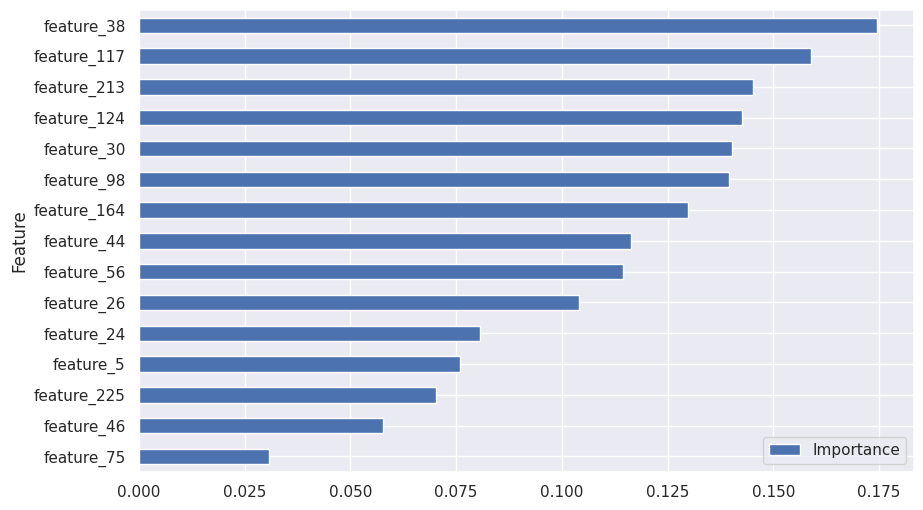

In [ ]:
coefficients = logreg.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.show()

# Бонусная часть (3 балла)

В разделе про бустинг мы обучали `LGBMClassifier` на довольно большом наборе фичей. Их количество можно сократить, при этом не теряя в качестве модели.

За начальный набор признаков можно взять все признаки (все 230) или признаки после отбора по IV.

**Ваша задача:** Отобрать признаки, подобрать оптимальные гиперпараметры и обучить `LGBMClassifier`.

Задание творческое) Можно использовать любые методы отбора признаков / оптимизации гиперпараметров.

**Чем меньше признаков, без ухудшения качества модели – тем лучше.**

Идеи для отбора признаков:

- Воспользоваться методами из модуля `sklearn.feature_selection` (точно можно попробовать RFE). Документация https://scikit-learn.org/stable/modules/feature_selection.html
- С помощью `BorutaPy` из библиотеки `boruta` (https://towardsdatascience.com/simple-example-using-boruta-feature-selection-in-python-8b96925d5d7a – статья может помочь разобраться с запуском алгоритма (мб не откроется без vpn))

Попробуем сделать отбор признаков при помощи **Permutation Importance** (используя стандартную имплементацию в ```sklearn```)

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# Отбирать будем на валидационной выборке и уже используя результаты отбора по IV
importance = permutation_importance(clf, df.loc[df['sample_part'] == 'val', features_optuna], df.loc[df['sample_part'] == 'val', TARGET],
                                    scoring='roc_auc', n_repeats=10, n_jobs=-1, random_state=42)

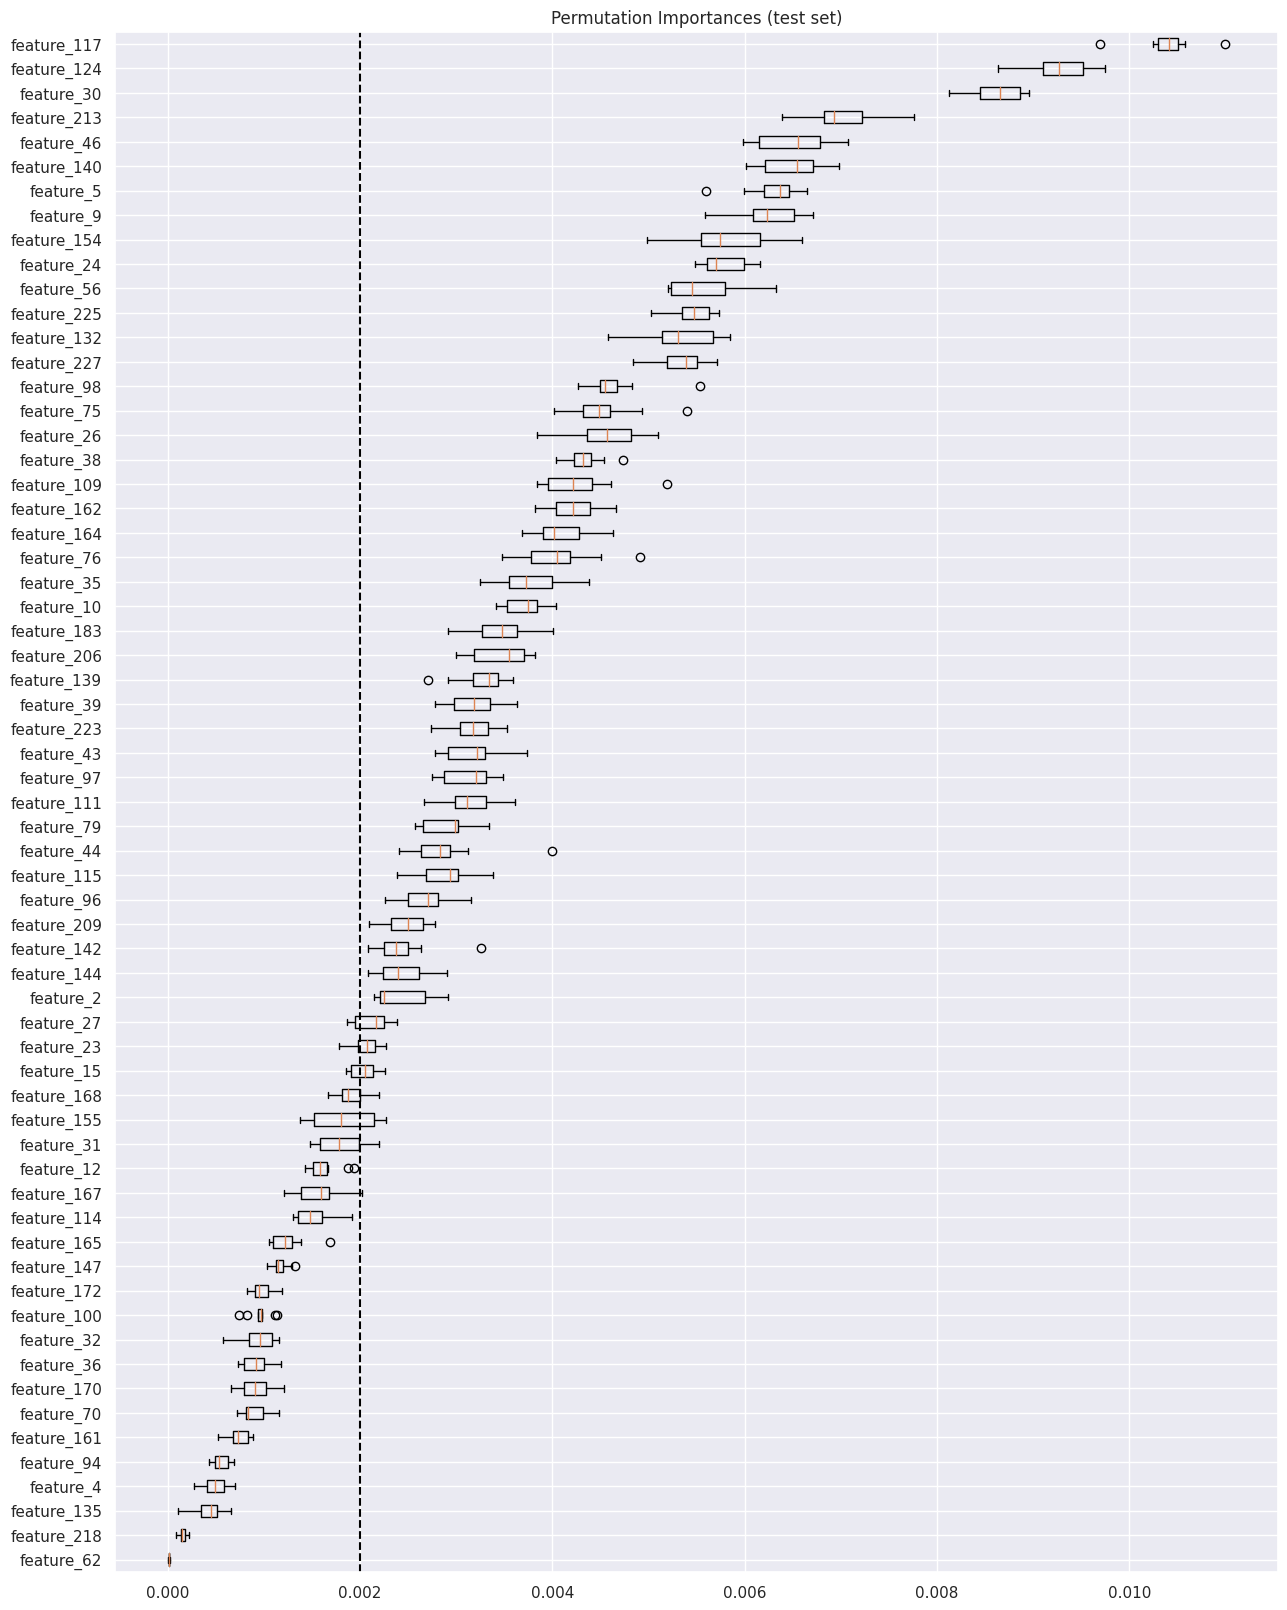

In [ ]:
sorted_idx = importance.importances_mean.argsort()

plt.figure(figsize=(15,20))
plt.boxplot(importance.importances[sorted_idx].T,
           vert=False,
           labels=np.array(features_optuna)[sorted_idx])
plt.axvline(x=0.002, linestyle='--', color='black')

plt.title("Permutation Importances (test set)")

plt.show()

In [ ]:
important_features = np.array(features_optuna)[importance.importances_mean > 0.002]

In [ ]:
important_features.shape # Уменьшили количество признаков на треть

(43,)

Подберем гиперпараметры как в пункте 1


In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=False),
        'num_leaves': trial.suggest_int('num_leaves', 2, 30),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 50, log=False),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 50, log=False),
        'random_state': 42
    }

    clf = LGBMClassifier(**params, verbosity=-1)
    clf.fit(
        X=df.loc[df['sample_part'] == 'train', important_features],
        y=df.loc[df['sample_part'] == 'train', TARGET]
    )
    preds = clf.predict_proba(df.loc[df['sample_part'] == 'val', important_features])[:, 1]
    auc_valid = roc_auc_score(
        y_true=df.loc[df['sample_part'] == 'val', TARGET],
        y_score=preds
    )

    return auc_valid

In [ ]:
study_new = optuna.create_study(direction='maximize')
study_new.optimize(objective, n_trials=30)

[I 2024-03-24 13:20:35,109] A new study created in memory with name: no-name-87978da1-9bcc-473d-8ca9-47e17553a45b
[I 2024-03-24 13:21:00,051] Trial 0 finished with value: 0.7384849383195726 and parameters: {'learning_rate': 0.2568876874522114, 'num_leaves': 30, 'n_estimators': 251, 'max_depth': 9, 'reg_alpha': 29.032461860684066, 'reg_lambda': 22.527595696646934}. Best is trial 0 with value: 0.7384849383195726.
[I 2024-03-24 13:21:13,957] Trial 1 finished with value: 0.7282256828557552 and parameters: {'learning_rate': 0.5639076195267482, 'num_leaves': 11, 'n_estimators': 202, 'max_depth': 5, 'reg_alpha': 26.006725106547655, 'reg_lambda': 14.230840317205645}. Best is trial 0 with value: 0.7384849383195726.
[I 2024-03-24 13:21:23,143] Trial 2 finished with value: 0.7199371942690627 and parameters: {'learning_rate': 0.6469901289040539, 'num_leaves': 25, 'n_estimators': 67, 'max_depth': 19, 'reg_alpha': 32.65622547603233, 'reg_lambda': 7.030960565044997}. Best is trial 0 with value: 0.738

In [ ]:
print(study_new.best_params)

{'learning_rate': 0.2568876874522114, 'num_leaves': 30, 'n_estimators': 251, 'max_depth': 9, 'reg_alpha': 29.032461860684066, 'reg_lambda': 22.527595696646934}


In [ ]:
clf = LGBMClassifier(**study_new.best_params, verbosity=-1)
clf.fit(
    X=df.loc[df['sample_part'] == 'train', important_features],
    y=df.loc[df['sample_part'] == 'train', TARGET]
)

preds_test = clf.predict_proba(df.loc[df['sample_part'] == 'test', important_features])[:, 1]
auc_test = roc_auc_score(
    y_true=df.loc[df['sample_part'] == 'test', TARGET],
    y_score=preds_test
)
print(auc_test)

0.7251344315387667


Итого, отбросили треть признаков, при этом практически не потеряв в качестве на тестовой выборке